# 計算パラスタ

## 手順

- オリジナルのフォルダを作成（クローン）
  - メッシュ情報は容量削減のため、シンボリックリンクにする
- パラメータの変更
  - 粘性係数を変更する
- 計算実行(Allrun）
  - レイノルズ数40以下はsimpleFoam
  - それ以上はpimpleFoam
- 抗力係数をプロット

# メッシュ情報はシンボリックリンクにする

In [6]:
import os
import shutil
import threading
from pathlib import Path
import subprocess
from PyFoam.RunDictionary.SolutionDirectory import SolutionDirectory
from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile

# クローン操作を行う関数（メッシュをシンボリックリンクとして作成）
def clone_case_with_symlink(template, destination):
    if not os.path.exists(destination):
        template.cloneCase(destination)
        print(f"クローンを作成しました: {destination}")
        
        # シンボリックリンクの作成: メッシュディレクトリのリンクを作成
        mesh_source = os.path.join(template.name, 'constant', 'polyMesh')
        mesh_link = os.path.join(destination, 'constant', 'polyMesh')

        if os.path.exists(mesh_link):
            shutil.rmtree(mesh_link)  # 既存のディレクトリがあれば削除

        os.symlink(mesh_source, mesh_link)  # シンボリックリンクを作成
        print(f"シンボリックリンクを作成しました: {mesh_link} -> {mesh_source}")
    else:
        print(f"ディレクトリが既に存在します: {destination}")

# Allrunをバックグラウンドで実行し、ログをファイルにリダイレクトする
def run_allrun(case_dir):
    try:
        # Allrunスクリプトを実行
        with open(os.path.join(case_dir, "log.Allrun"), "w") as log_allrun:
            subprocess.run('./Allrun', cwd=case_dir, check=True, stdout=log_allrun, stderr=log_allrun)
    except subprocess.CalledProcessError as e:
        print(f"エラーが発生しました: {e}")

# パラメータスタディを実行する関数
def run_parameter_study(Re, U, D, resultDir):
    for ReI in Re:
        nu = U * D / ReI
        fileName_i = f"Re{ReI:.0f}"

        # テンプレートケースのディレクトリ
        if ReI<=40:
            template_case = "../002_cylinder2D_base/simpleFoam"
        else:
            template_case = "../002_cylinder2D_base/pimpleFoam"
            
        templatePara = SolutionDirectory(template_case)
        
        case_dir = os.path.join(os.getcwd(), resultDir, fileName_i)
    
        # クローン操作を行う（メッシュはシンボリックリンク）
        clone_case_with_symlink(templatePara, case_dir)
            
        print("全てのクローン操作とファイル編集が完了しました。")
        
        # transportPropertiesファイルの編集
        transportPropertiesFile = ParsedParameterFile(os.path.join(case_dir, "constant", "transportProperties"))
        transportPropertiesFile["nu"] = nu
        transportPropertiesFile.writeFile()

        # Allrunをバックグラウンドで実行
        allrun_thread = threading.Thread(target=run_allrun, args=(case_dir,))
        allrun_thread.start()

        # 他の操作を続ける
        print(f"====== Allrunをバックグラウンドで実行中...{fileName_i} ====== ")

        # スレッドの終了を待つ
        allrun_thread.join()

# メインの処理
def main():
    Re = [2, 5, 10, 20, 40, 100, 200, 500, 1000, 2000, 5000, 10000]
    U = 0.15
    D = 20 / 1000
    resultDir = Path("results")
    
    # resultDirディレクトリを作成
    resultDir.mkdir(exist_ok=True, parents=True)

    # パラメータスタディを実行
    parameter_study_thread = threading.Thread(target=run_parameter_study, args=(Re, U, D, resultDir))
    parameter_study_thread.start()
    
# メインの処理を実行
if __name__ == "__main__":
    main()

クローンを作成しました: /home/kamakiri/OpenFOAM/kamakiri-v2406/run/17_gijyutusyo/005_cylinder2DParaSutdy/results/Re5000
シンボリックリンクを作成しました: /home/kamakiri/OpenFOAM/kamakiri-v2406/run/17_gijyutusyo/005_cylinder2DParaSutdy/results/Re5000/constant/polyMesh -> /home/kamakiri/OpenFOAM/kamakiri-v2406/run/17_gijyutusyo/002_cylinder2D_base/pimpleFoam/constant/polyMesh
全てのクローン操作とファイル編集が完了しました。
====== Allrunをバックグラウンドで実行中...Re5000 ====== 
クローンを作成しました: /home/kamakiri/OpenFOAM/kamakiri-v2406/run/17_gijyutusyo/005_cylinder2DParaSutdy/results/Re10000
シンボリックリンクを作成しました: /home/kamakiri/OpenFOAM/kamakiri-v2406/run/17_gijyutusyo/005_cylinder2DParaSutdy/results/Re10000/constant/polyMesh -> /home/kamakiri/OpenFOAM/kamakiri-v2406/run/17_gijyutusyo/002_cylinder2D_base/pimpleFoam/constant/polyMesh
全てのクローン操作とファイル編集が完了しました。
====== Allrunをバックグラウンドで実行中...Re10000 ====== 


# 抗力係数のグラフ化

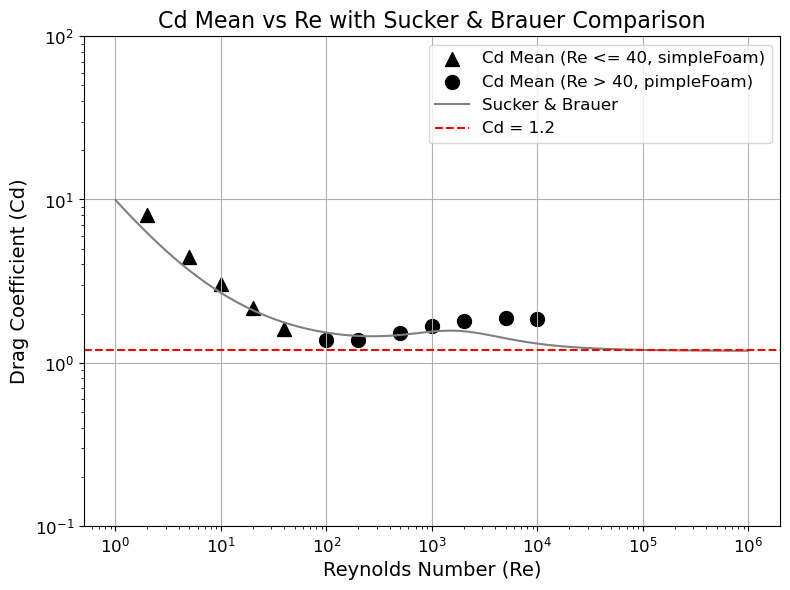

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sucker & Brauer (Eq. 4) に基づくCdを計算する関数
def calculate_Cd(Re):
    term1 = 1.18
    term2 = 6.8 / (Re ** 0.89)
    term3 = 1.96 / np.sqrt(Re)
    term4 = 0.0004 * Re / (1 + 3.63 * 1e-7 * Re**2)
    return term1 + term2 + term3 + term4

# Reの値を定義
Re_user = [2, 5, 10, 20, 40, 100, 200, 500, 1000, 2000, 5000, 10000]
result_dir = "results"  # 解析結果が格納されているディレクトリ

Cd_averages = []

# 各Reについて処理を行う
for ReI in Re_user:
    # coefficient.datのファイルパスを定義
    file_path = os.path.join(result_dir, f"Re{ReI}", "postProcessing", "forces", "0", "coefficient.dat")
    
    # データを読み込み
    if os.path.exists(file_path):
        try:
            data = pd.read_csv(file_path, delim_whitespace=True, comment="#", header=None)
            # 列名の設定
            data.columns = ["Time", "Cd", "Cd(f)", "Cd(r)", "Cl", "Cl(f)", "Cl(r)", "CmPitch", "CmRoll", "CmYaw", "Cs", "Cs(f)", "Cs(r)"]
            
            if ReI <= 40:
                # simpleFoamの場合、最後の100ステップのデータを使う
                data_last_100 = data.tail(100)
                Cd_mean = data_last_100["Cd"].mean()
            else:
                # pimpleFoamの場合、15秒以降のデータを使う
                data_filtered = data[data["Time"] >= 15]
                Cd_mean = data_filtered["Cd"].mean()
            
            Cd_averages.append(Cd_mean)
        except Exception as e:
            print(f"データ読み込み中にエラーが発生しました: Re={ReI}, エラー: {e}")
            Cd_averages.append(np.nan)
    else:
        print(f"ファイルが見つかりません: Re={ReI}, パス: {file_path}")
        Cd_averages.append(np.nan)

# NaNを除いた有効なデータのみを使ってグラフを描画
valid_indices = [i for i, value in enumerate(Cd_averages) if not np.isnan(value)]
if valid_indices:
    Re_valid = [Re_user[i] for i in valid_indices]
    Cd_valid = [Cd_averages[i] for i in valid_indices]

    # Sucker & Brauerの理論式に基づくCdを計算
    Re_theory = np.logspace(0, 6, 100)  # 理論式用のRe範囲
    Cd_theory = calculate_Cd(Re_theory)

    plt.figure(figsize=(8, 6))

    # ユーザーデータのプロット
    Re_small = [Re_user[i] for i in valid_indices if Re_user[i] <= 40]
    Cd_small = [Cd_averages[i] for i in valid_indices if Re_user[i] <= 40]
    plt.scatter(Re_small, Cd_small, marker='^', color='black', s=100, label='Cd Mean (Re <= 40, simpleFoam)')

    Re_large = [Re_user[i] for i in valid_indices if Re_user[i] > 40]
    Cd_large = [Cd_averages[i] for i in valid_indices if Re_user[i] > 40]
    plt.scatter(Re_large, Cd_large, marker='o', color='black', s=100, label='Cd Mean (Re > 40, pimpleFoam)')

    # Sucker & Brauerの理論式のプロット
    plt.plot(Re_theory, Cd_theory, label='Sucker & Brauer', color='gray')

    plt.xlabel('Reynolds Number (Re)', fontsize=14)
    plt.ylabel('Drag Coefficient (Cd)', fontsize=14)
    plt.title('Cd Mean vs Re with Sucker & Brauer Comparison', fontsize=16)
    plt.grid(True)
    plt.xscale('log')  # x軸を対数スケールに設定
    plt.yscale('log')  # y軸を対数スケールに設定
    plt.xticks([1, 10, 100, 1000, 10000, 100000, 1e6], fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0.1, 100)
    plt.axhline(y=1.2, color='red', linestyle='--', label='Cd = 1.2')
    plt.legend(fontsize=12)
    plt.tight_layout()

    # PDFで保存
    plt.savefig("Cd_vs_Re_with_theory.pdf")
    plt.show()
else:
    print("有効なデータが見つかりませんでした。解析結果を確認してください。")

# ストローハル数のグラフ化

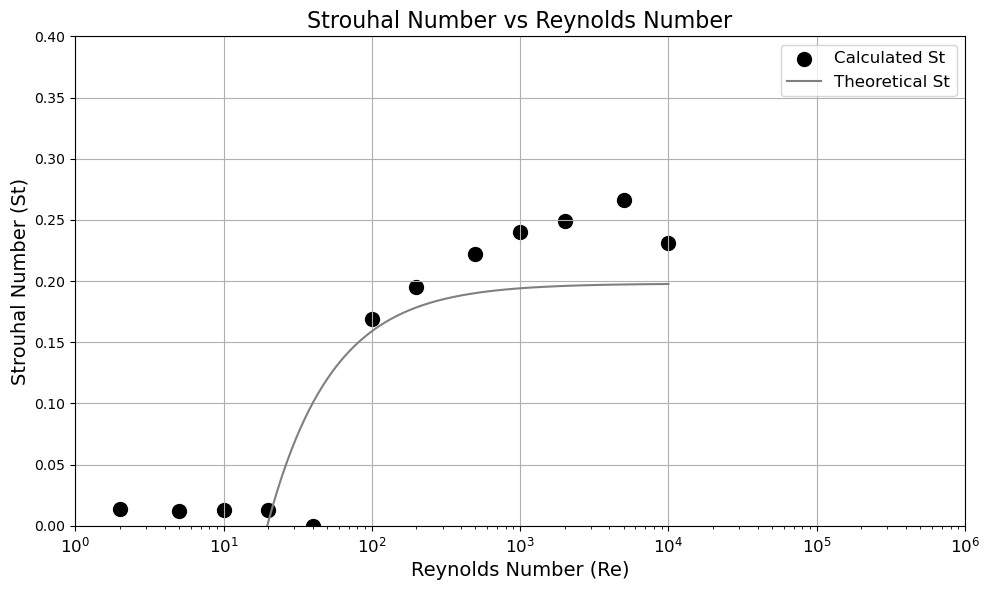

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

# 円柱の直径と流速を設定
d = 20 / 1000  # 円柱の直径 (m)
U = 0.15  # 流速 (m/s)

# レイノルズ数のリスト
Re_user = [2, 5, 10, 20, 40, 100, 200, 500, 1000, 2000, 5000, 10000]
result_dir = "results"  # 解析結果が格納されているディレクトリ

St_values = []

# 各Reについて解析
for ReI in Re_user:
    # coefficient.datのファイルパスを定義
    file_path = os.path.join(result_dir, f"Re{ReI}", "postProcessing", "forces", "0", "coefficient.dat")
    
    # データを読み込み
    if os.path.exists(file_path):
        try:
            data = pd.read_csv(file_path, delim_whitespace=True, comment="#", header=None)
            data.columns = ["Time", "Cd", "Cd(f)", "Cd(r)", "Cl", "Cl(f)", "Cl(r)", "CmPitch", "CmRoll", "CmYaw", "Cs", "Cs(f)", "Cs(r)"]

            # 15秒以降のデータを抽出
            time_filtered = data["Time"][data["Time"] >= 15]
            Cl_filtered = data["Cl"][data["Time"] >= 15]

            # 補間を用いて均等な時間軸を生成
            interp_func = interp1d(time_filtered, Cl_filtered, kind='linear')
            new_time = np.linspace(time_filtered.iloc[0], time_filtered.iloc[-1], num=len(Cl_filtered))
            new_Cl = interp_func(new_time)

            # FFTを実行して周波数成分を取得
            N = len(new_Cl)
            dT = new_time[1] - new_time[0]
            yf = np.fft.fft(new_Cl)
            xf = np.fft.fftfreq(N, dT)

            # ピークを検出してストローハル数を計算
            peaks, _ = find_peaks(2.0 / N * np.abs(yf[:N // 2]), height=0)
            peak_freqs = xf[peaks]
            peak_amplitudes = 2.0 / N * np.abs(yf[peaks])

            if len(peak_amplitudes) > 0:
                max_peak_index = np.argmax(peak_amplitudes)
                max_peak_freq = peak_freqs[max_peak_index]
                St = max_peak_freq * d / U  # ストローハル数の計算
                St_values.append(St)
            else:
                St_values.append(np.nan)

        except Exception as e:
            print(f"データ読み込み中にエラーが発生しました: Re={ReI}, エラー: {e}")
            St_values.append(np.nan)
    else:
        print(f"ファイルが見つかりません: Re={ReI}, パス: {file_path}")
        St_values.append(np.nan)

# 理論的なストローハル数の式をプロット用に定義
def theoretical_St(Re):
    return 0.198 * (1 - 19.7 / Re)

# プロット範囲のレイノルズ数
Re_theory = np.logspace(1, 4, 100)
St_theory = theoretical_St(Re_theory)

# プロットの作成
plt.figure(figsize=(10, 6))
plt.scatter(Re_user, St_values, marker='o', color='black', s=100, label='Calculated St')
plt.plot(Re_theory, St_theory, linestyle='-', color='gray', label='Theoretical St')

plt.xlabel('Reynolds Number (Re)', fontsize=14)
plt.ylabel('Strouhal Number (St)', fontsize=14)
plt.title('Strouhal Number vs Reynolds Number', fontsize=16)
plt.xscale('log')
plt.ylim(0, 0.4)
plt.xticks([1, 10, 100, 1000, 10000, 100000, 1e6], fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# PDFに保存
plt.savefig("Strouhal_vs_Reynolds.pdf")
plt.show()